In [1]:
from sage.all import *
from sage.matrix.berlekamp_massey import berlekamp_massey
def mat_gen(q, n):
    D = diagonal_matrix(GF(q), rand_list(n, q))
    T = toeplitz(rand_list(n, q), rand_list(n - 1, q), GF(q))
    J = jordan_block(random.randint(2, q), n)
    S = random_matrix(GF(q), n, n, sparse=True, density=0.05)
    return [D, T, J, S]

In [2]:
def random_vector(n, f):
    return vector(f, [f.random_element() for _ in range(n)])
def krylov(A, q):
    f = GF(q)
    n = A.nrows()
    u = random_vector(n, f)
    v = random_vector(n, f)
    return [u*(A^i*v) for i in range(2*n)]

In [3]:
def early_BM(q, sequence, n, c=3):
    ω = c*log(n, q)
    f = GF(q)
    R = PolynomialRing(f, "x")
    sequence = [f(s) for s in sequence]
    C = [f(1)]
    B = [f(1)]
    L = 0
    m = 1
    streak = 1
    b = f(1)
    stop = 0
    for k in range(len(sequence)):
        d = sequence[k] + sum(C[i] * sequence[k - i] for i in range(1, L + 1))
        if d == 0:
            m += 1
            streak += 1
            if streak >= ω:
                stop = k
                break
        elif 2 * L <= k:
            T = C[:]
            C += [f(0)] * (m + len(B) - len(C))
            for i in range(len(B)):
                C[i + m] -= d / b * B[i]
            L = k + 1 - L
            B = T
            b = d
            m = 1
            streak = 1
        else:
            C += [f(0)] * (m + len(B) - len(C))
            for i in range(len(B)):
                C[i + m] -= d / b * B[i]
            m += 1
            streak = 1
    else: 
        stop = 2*n
    # result processing before return
    C = C[::-1]
    while len(C) > 1 and C[0] == 0:
        C = C[1:]
    return R(C), stop

In [4]:
from collections import defaultdict

# Settings
size_range = range(10, 100)  # matrix sizes from 10 to 100 inclusive
primes_list = prime_range(1, 10000)  # primes under 1000
trials = 50  # number of trials per test

# Store where early BM fails compared to standard BM
fail_at = {}

# Loop over matrix sizes
for size in size_range:
    print(size)
    mat = jordan_block(2, size)
    minpoly = mat.minpoly()
    
    for q in primes_list:
        success_std = 0
        success_early = 0

        for _ in range(trials):
            try:
                k = krylov(mat, q)
                b_early, _ = early_BM(q, k, mat.nrows())
                b_std = berlekamp_massey(k)
                
                if b_std == minpoly:
                    success_std += 1
                if b_early == minpoly:
                    success_early += 1
            except Exception as e:
                print(f"[size={size}, q={q}] Error: {e}")
                continue

        # Avoid division by zero
        if success_std == 0:
            if success_early > 0:
                ratio = float('inf')
            else:
                ratio = 1.0
        else:
            ratio = success_early / success_std
            # print(float(ratio))

        if ratio < 0.8:
            fail_at[size] = q
            break

10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52


KeyboardInterrupt: 

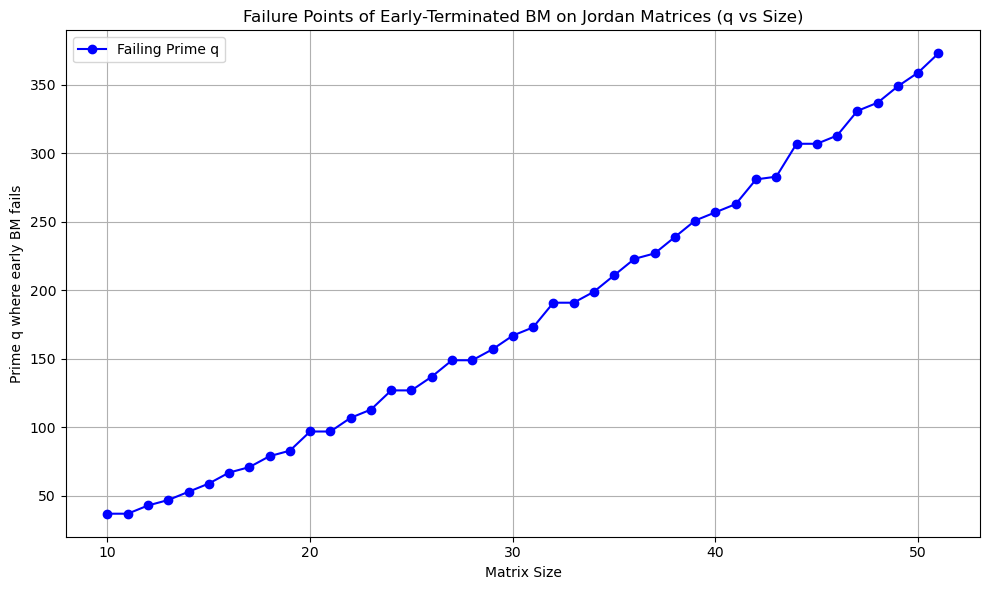

In [7]:
from matplotlib import pyplot as plt
sizes = list(fail_at.keys())
qs = list(fail_at.values())

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sizes, qs, marker='o', linestyle='-', color='blue', label='Failing Prime q')
plt.title("Failure Points of Early-Terminated BM on Jordan Matrices (q vs Size)")
plt.xlabel("Matrix Size")
plt.ylabel("Prime q where early BM fails")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()